# 1. Preparation

Make sure all libraries are installed

In [1]:
import numpy as np
import nmrglue as nmr
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.optimize import curve_fit
from scipy.ndimage import map_coordinates ##This function returns position of a given point in np.ndarray index coordinates
import os
import shutil

In [16]:
print(nmr.__version__)
print(pd.__version__)

print('''\nExpected: 
nmrglue\t0.9 
pandas\t1.4.2
''')

0.9
1.4.2

Expected: 
nmrglue	0.9 
pandas	1.4.2



# 1.1 Definitions

### Service

In [3]:
def grid(peak_list, roi, res=(1, 1, 1), N=(3, 3, 5)):
    H_cent = peak_list.loc[roi, :, 'HN'].values[0,0]
    N_cent = peak_list.loc[roi, :, 'N'].values[0,0]
    CA_cent = peak_list.loc[roi, :, 'CA'].values[0,0]
    try:
        CB_cent = peak_list.loc[roi, :, 'CB'].values[0,0]
    except:
        CB_cent = peak_list.loc[roi, :, 'CA'].values[0,0]
    H, N, CA = np.mgrid[H_cent-N[0]*res[0]:H_cent+N[0]*res[0]:N[0]*1j, 
                        N_cent-N[1]*res[1]:N_cent+N[1]*res[1]:N[1]*1j,
                        CA_cent-N[2]*res[2]:CA_cent+N[2]*res[2]:N[2]*1j,
                        ]
    return {"HN": H, "N": N, "CA": CA} 
    #### include mapping into here!
    
def coord_transform(arr1, limits1=(0,1), limits2=(-10,10)):
    arr1 = np.asarray(arr1)
    return (limits2[0]-limits2[1])*(arr1-limits1[0]) / (limits1[0] - limits1[1]) + limits2[0]

def key_from_val(dic, val):
    return dict((new_val,new_k) for new_k,new_val in dic.items()).get(val)

### Extracting slices

In [ ]:
def slice3D(roi, peaklist, spectrum, width=(4, 4, 4), idx=None, file_format="CCPN", atoms=("CA", "N", "HN")):       
    center_ppm = {}
    center_pts = {}
    
    if idx is not None:
        cube = spectrum[idx]
    else:
        for atom in atoms:
            if  file_format=="CCPN":
                if peaklist.loc[roi].shape[0] > 1:
                    center_ppm[atom] = peaklist.loc[roi, :].where(
                        peaklist.loc[roi, :].Height == peaklist.loc[roi, :].Height.max()
                                                                    )[f"CS_{atom}"].dropna().values[0]
                else:
                    center_ppm[atom] = peaklist.loc[roi, :][f"CS_{atom}"].values[0]
            else: #TALOS format
                center_ppm[atom] = peaklist.loc[roi, :, atom].values[0,0]
            center_pts[atom] = coord_transform(center_ppm[atom], 
                                      ppm_limits[dim_map.loc[dim_map[dim_map['Atom']==atom].index[0]]["Axis"]], 
                                      pts_limits[dim_map.loc[dim_map[dim_map['Atom']==atom].index[0]]["Axis"]])    
    
    idx = (slice(round(center_pts[dim_map.loc[0, "Atom"]])-width[0]//2, 
                 round(center_pts[dim_map.loc[0, "Atom"]])+width[0]//2, 1), 
           slice(round(center_pts[dim_map.loc[1, "Atom"]])-width[1]//2, 
                 round(center_pts[dim_map.loc[1, "Atom"]])+width[1]//2, 1),
           slice(round(center_pts[dim_map.loc[2, "Atom"]])-width[2]//2, 
                 round(center_pts[dim_map.loc[2, "Atom"]])+width[2]//2, 1),
          )  
    cube = spectrum[idx] 
    return idx, cube

### Fitting

In [ ]:
def gauss1d(x, I, x0, sigma):
    return I * np.exp(-1/2*(x-x0)**2/(sigma**2))

def twoD_Gaussian(xdata_tuple, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                                 
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0)         
                        + c*((y-y0)**2))) 
    
    #f = I * np.exp(- 1/(2*(1-theta**2)) *( 
    #                 ((x-x0)/sigma_x))**2 
    #               - 2*theta*(x-x0)*(y-y0)/(sigma_x*sigma_y) 
    #               + ((y-y0)/sigma_y)**2
    #              )
    return g.ravel()

### Functions for making projections

In [48]:
# Just making a 2D projection
def proj_to_plot(spectrum, dimX="HN", dimY="N"):
    ind1, ind2 = dim_map[dim_map['Atom']==dimX].index[0], dim_map[dim_map['Atom']==dimY].index[0]
    print(ind1, ind2)
    axis_to_degen = dim_map.drop(index=[ind1,ind2]).index.values
    print(axis_to_degen)
    #TODO: roll axes accordingly
    #spectrum = np.transpose(spectrum, (ind2, ind1, axis_to_degen[0]))
    proj = spectrum.sum(axis=tuple(axis_to_degen))
    proj = proj / proj.max()
    x_space = np.linspace(ppm_limits[dim_map.loc[ind1, 'Axis']][1], ppm_limits[dim_map.loc[ind1, 'Axis']][0], proj.shape[0])
    y_space = np.linspace(ppm_limits[dim_map.loc[ind2, 'Axis']][1], ppm_limits[dim_map.loc[ind2, 'Axis']][0], proj.shape[1])
    return x_space, y_space, proj

# PLOT a 1D projection of a 3D cube
def projs_1D(roi, peaklist, spectrum, width=(10,10,10), idx=None, plot=True):
    
    if idx is not None:
        cube = spectrum[idx]
    else:
        idx, cube = slice3D(roi, width=width)
    
    if plot:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
        fig.suptitle(f"Residue {roi}")

    projs = {}
    xs = {}
    for i in range(cube.ndim):
        proj=cube.sum(axis=tuple(dim_map.drop(index=i).index.values))
        projs[dim_map.loc[i, "Atom"]] = proj
        
        x_left, x_right = coord_transform([idx[i].start, idx[i].stop],
                    pts_limits[dim_map.loc[i, "Axis"]],
                    ppm_limits[dim_map.loc[i, "Axis"]])
        x=np.linspace(x_left, x_right, proj.shape[0])
        xs[dim_map.loc[i, "Atom"]] = x
        if plot:
            ax = np.ravel(axs)[i]
            ax.plot(x, proj)
            ax.set_title(dim_map.loc[i, "Atom"])
            ax.invert_xaxis()
    if plot:
        fig.tight_layout()
    return xs, projs 
    plt.show()

## 1.2 Reading the 3D data

### Reading peak lists exported from CCPN 
* The file needs to be tab-separated

In [4]:
path_to_tab_file = "D:\Data\Hydrophobin\CCPN peak lists\Hydrophobin_HNCB.tab" # The peak list file

In [5]:
spectrum_peak_list = pd.read_csv(path_to_tab_file, sep="\t", index_col=0)
spectrum_peak_list = spectrum_peak_list.mask(spectrum_peak_list=='None').dropna()
spectrum_peak_list.columns = ['#', 
                          "CS_HN", "CS_CB", "CS_N", 
                          'Asgn', 'Asgn_CB', 'Asgn_N', 
                          'Height', 'Volume', 
                          'LW_HN', 'LW_CB', 'LW_N']
spectrum_peak_list.drop(['#', 'Asgn_CB', 'Asgn_N'], axis=1, inplace=True)
spectrum_peak_list["ResNum"] = spectrum_peak_list["Asgn"].apply(lambda s: int(''.join(list(s)[:3]))) #1st symbol is whitespace
spectrum_peak_list["ResType"] = spectrum_peak_list["Asgn"].apply(lambda s: ''.join(list(s)[3]))
spectrum_peak_list.set_index(["ResNum", "ResType"], inplace=True)

spectrum_peak_list#.tail(10)

,,CS_HN,CS_CB,CS_N,Asgn,Height,Volume,LW_HN,LW_CB,LW_N
ResNum,ResType,,,,,,,,,
20,C,7.86137,38.97822,107.12908,20CH,51468600.0,1.322310e+09,228.64590,249.25781,157.68309
21,Q,7.34697,27.97183,115.31176,21QH,76488200.0,1.981600e+09,303.89270,234.35110,141.52646
22,S,9.03520,64.34026,114.20267,22SH,71945100.0,1.841870e+09,250.59848,211.85719,375.79377
31,C,8.92641,46.36302,118.31949,31CH,55134200.0,1.395100e+09,281.53308,175.82377,151.93383
32,V,8.96249,34.71638,122.44585,32VH,107968000.0,2.772320e+09,324.70047,219.67849,208.53251
33,V,9.24087,27.43223,125.11434,33VH,83658600.0,2.110120e+09,298.04077,164.45737,206.71705
35,V,9.38636,35.16632,125.15115,35VH,161036000.0,4.023410e+09,264.36462,160.37690,167.74584
36,I,8.70857,34.50347,120.78175,36IH,114897000.0,2.914040e+09,317.70827,172.07718,202.36144
38,S,7.77662,69.18740,109.62731,38SH,229960000.0,5.720160e+09,195.75397,158.14526,303.94712


### Reading the spectrum:

In [6]:
#in UCSF or Pipe format (mind the extension); 3D
path_to_spectrum = "D:\Spectra\Hydrophobin\hcaCBcaNH_18.ucsf" 

# Working directory where all output tables and figures will be written:
dataDir = "C:\\Users\\Admin\\Documents\\IPythonNotebooks\\Analysis of the peak shapes\\Hydrophobin\\IndPeaks\\3D\\HNCB\\" 

In [10]:
try: del spectrum
except: pass

form = path_to_spectrum.split('.')[-1]
if form == "ucsf":
    spectrum_dic, spectrum = nmr.sparky.read(path_to_spectrum)
    C = nmr.convert.converter()
    C.from_sparky(spectrum_dic, spectrum)
    spectrum_dic, spectrum  = C.to_pipe()
elif form == "ft":
    spectrum_dic, spectrum = nmr.pipe.read(path_to_spectrum)
else:
    print ("Format not detected. Please, check and update file extention accordingly")
    
print(f'''Obs. freq. order:\t3 {spectrum_dic["FDF3OBS"]} MHz
                        2 {spectrum_dic["FDF2OBS"]} MHz
                        1 {spectrum_dic["FDF1OBS"]} MHz

Often does not reflect the real order - always double-check manually!!!''')

Obs. freq. order:	3 81.08822631835938 MHz
                        2 800.1541748046875 MHz
                        1 201.20767211914062 MHz

Often does not reflect the real order - always double-check manually!!!


### Dimension mapping - MANUAL INTERVENTION

Establish correct mapping of the dataset (i.e. spectrum) dimensions to the 1) atoms; 2) dimensions IDs (in the spectrum header, which is currently written into `spectrum_dic`

In [12]:
                        #NumPy dimension ; #Atom ; #Dim ID 
    
dim_map = pd.DataFrame(data = {
                                0: ("N",   "w3"),             ###### Correct here, if needed
                                1: ("CB",  "w1"),             ###### Correct here, if needed
                                2: ("HN",  "w2"),            ###### Correct here, if needed
                                }, index=['Atom', 'Axis'])   
dim_map = dim_map.transpose()
dim_map

,Atom,Axis
0,N,w3
1,CB,w1
2,HN,w2


### Referencing - MANUAL INTERVENTION

Define and adjust the ppm scale:
* Write the correct offset values into the `_FDF*CAR` parameters from the CCPN project (v.2) (`Spectra -> Referencing; Offset`):

In [13]:
## Manial referencing! (take this from CCPN project were you reference your spetra)

spectrum_dic["_FDF3CAR"] = 119.606 # N
spectrum_dic["_FDF2CAR"] = 8.569   # H
spectrum_dic["_FDF1CAR"] = 57.20   # CA

#HNCA

spectrum_dic["_FDF3CAR"] = 119.606 # N
spectrum_dic["_FDF2CAR"] = 8.669   # H
spectrum_dic["_FDF1CAR"] = 51.311   # CB

In [14]:
# Mind the order!! 
ppm_limits = {"w3": (spectrum_dic["_FDF3CAR"] - spectrum_dic["FDF3SW"]/(2*spectrum_dic["FDF3OBS"]), spectrum_dic["_FDF3CAR"] + spectrum_dic["FDF3SW"]/(2*spectrum_dic["FDF3OBS"])),
              "w2": (spectrum_dic["_FDF2CAR"] - spectrum_dic["FDF2SW"]/(2*spectrum_dic["FDF2OBS"]), spectrum_dic["_FDF2CAR"] + spectrum_dic["FDF2SW"]/(2*spectrum_dic["FDF2OBS"])), 
              "w1": (spectrum_dic["_FDF1CAR"] - spectrum_dic["FDF1SW"]/(2*spectrum_dic["FDF1OBS"]), spectrum_dic["_FDF1CAR"] + spectrum_dic["FDF1SW"]/(2*spectrum_dic["FDF1OBS"])) 
             }
pts_limits = dict((k,v) for k,v in zip('w3 w2 w1'.split(), [(x, 0) for x in spectrum.shape])) # Mind the order: here we take into account that the scales are inverted

ppm_limits

{'w3': (99.05225623659487, 140.15974376340512),
 'w2': (5.852535643689274, 11.485464356310727),
 'w1': (11.310998786623678, 91.31100121337633)}

### Check visually if the dimensions are mapped correctly

In [46]:
dimY = "HN"
dimX = "N"

Plotting:

0 2
[1]


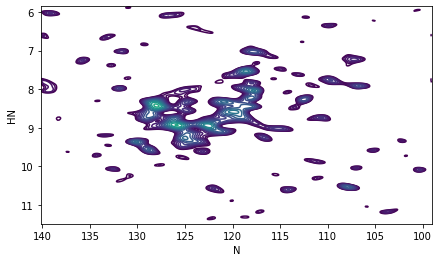

In [47]:
x_lbls, y_lbls, z = proj_to_plot(spectrum, dimX=dimX, dimY=dimY)
cl = [0.28*1.1**x for x in range(18)]

fig, ax = plt.subplots(figsize=(7,4))
ax.contour(x_lbls, y_lbls, z.T, cl)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(dimX)
ax.set_ylabel(dimY)
plt.show()

#### print(dimX, dimY)

In [43]:
plt.close()

# 2. Peak-by-peak analysis

## 2.1 Extracting a single peak
Here we carefully cut a box with each individual peak, avoiding parts of the overlapping peaks as much as possible

In [910]:
roi=53
width=(25,16,120)

idx, cube = slice3D(roi, peaklist=spectrum_peak_list, spectrum=spectrum, width=width, file_format="CCPN", atoms=("CB", "N", "HN"))
idx

(slice(97, 121, 1), slice(314, 330, 1), slice(442, 562, 1))

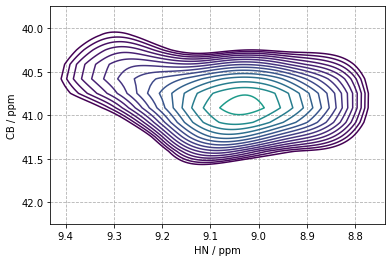

In [925]:
#Determine the axes - follow the order of dimemsions in the spectrum
dimX = "CB"
dimY = "HN"

#### Determine how to project the 3D cube
ax_id1, ax_id2 = dim_map[dim_map['Atom']==dimX].index[0], dim_map[dim_map['Atom']==dimY].index[0]
axis_to_degen = dim_map.drop(index=[ax_id1,ax_id2]).index.values

proj = cube.sum(axis=tuple(axis_to_degen))
proj /= proj.max()

#### Make axes in ppm 
x_left, x_right = coord_transform([idx[ax_id1].start, idx[ax_id1].stop],
                pts_limits[dim_map.loc[ax_id1, "Axis"]],
                ppm_limits[dim_map.loc[ax_id1, "Axis"]])

y_left, y_right = coord_transform([idx[ax_id2].start, idx[ax_id2].stop],
                pts_limits[dim_map.loc[ax_id2, "Axis"]],
                ppm_limits[dim_map.loc[ax_id2, "Axis"]])

y = np.linspace(x_left, x_right, proj.shape[0]) #Transpose :)
x = np.linspace(y_left, y_right, proj.shape[1])

###
cl = [0.25*1.1**x for x in range(20)]

plt.close()
fig, ax = plt.subplots()
ax.contour(x, y, proj, cl)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_ylabel(dimX+' / ppm') #Transpose :)
ax.set_xlabel(dimY+' / ppm') #Transpose :)
#ax.set_title(f'{roi}{peak_list.loc[roi,:,:].index[0][0]}')
ax.grid(True, ls="--")
plt.show()

### 2.1.1 1D projections of the 3D block, containing the peak of interest

#### Adjusting the limits of the box - MANUAL INTERVENTION

In [913]:
idx

(slice(97, 121, 1), slice(314, 330, 1), slice(442, 562, 1))

Correct the box limits (in points):

In [926]:
#         N                   CA                  HN             
idx = (slice(97, 121, 1), slice(314, 330, 1), slice(420, 562, 1))
cube = spectrum[idx]

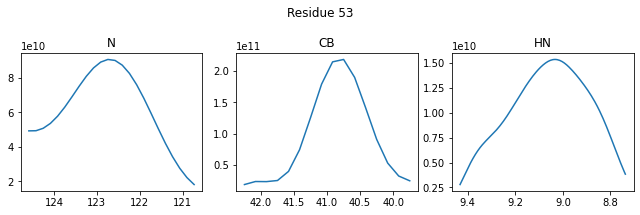

In [927]:
plt.close()
projs_1D(roi, peaklist=spectrum_peak_list, spectrum=spectrum, idx=idx, plot=True)
plt.show()

#### Writing the data into the files

In [928]:
#print(os.getcwd())
dataDir = "C:\\Users\\Admin\\Documents\\IPythonNotebooks\\Analysis of the peak shapes\\Hydrophobin\\IndPeaks\\3D\\HNCB\\"
print(dataDir)
try: shutil.rmtree(os.path.join(dataDir, str(roi)))
except: pass
os.mkdir(os.path.join(dataDir, str(roi)))

xs, projs = projs_1D(roi, peaklist=spectrum_peak_list, spectrum=spectrum, idx=idx, plot=False)

fname_arr = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak.npy")
np.save(fname_arr, cube)

for key in projs:
    fname_p = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+key+"_proj.npy")
    np.save(fname_p, projs[key])
    print("Projection saved as:\t" + fname_p)
    
for key in xs:
    fname_x = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+key+"_X.npy")
    np.save(fname_x, xs[key])
    print("X-axis saved as:\t" + fname_x)

fname_idx =os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_slice")
with open(fname_idx, "w+") as f:
    f.write(str(idx))
print(fname_idx)
print()

C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\
Projection saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53N_proj.npy
Projection saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53CB_proj.npy
Projection saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53HN_proj.npy
X-axis saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53N_X.npy
X-axis saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53CB_X.npy
X-axis saved as:	C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53\53HN_X.npy
C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\53

# 3. Read and fit the extracted peaks

In [51]:
# Calculating spectral resolution - converting points to Herz
res_H = spectrum_dic["FDF2SW"] / spectrum.shape[2]
res_CA = spectrum_dic["FDF1SW"] / spectrum.shape[1]
res_N = spectrum_dic["FDF3SW"] / spectrum.shape[0]
print(f"HN: {res_H} Hz; CA: {res_CA} Hz; N: {res_N} Hz")

HN: 3.9125099182128906 Hz; CA: 31.43869972229004 Hz; N: 13.020833015441895 Hz


# 3. 1D fits

This code fits the peaks with a Gaussian (`gaussian1D()` defined above; `scipy.optimize.curvefit` framework is used for the fitting). In majority of cases fitting will work automatically and right away. Sometimes, however, manual adjustments of the fitted region or the peak center are required (especially when the target signal has two maxima!!!) - in this case go through all the difficult peaks manually and adjust fitting parameters

In [53]:
dataDir = "C:\\Users\\Admin\\Documents\\IPythonNotebooks\\Analysis of the peak shapes\\Hydrophobin\\IndPeaks\\3D\\HNCB\\"

The data will be organised in a data frame. 

Creating an EMPTY data frame (CAUTION! OVERWRITES THE DATA THAT WAS NOT WRITTEN INTO A FILE!!!):

In [670]:
ind_col = pd.MultiIndex.from_product([["HN", "CB", "N"],["Int", "x0", "LW"]], names=["Atom", "Param"])
spectrum_proj_fit = pd.DataFrame(index=spectrum_peak_list.index, columns=ind_col)
spectrum_proj_fit.head(5)

Atom             HN             CB              N          
Param           Int   x0   LW  Int   x0   LW  Int   x0   LW
ResNum ResType                                             
20     C        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
21     Q        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
22     S        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
31     C        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
32     V        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

#### Fitting:

In [931]:
atom='CB' # 'HN' # 'N'

from scipy.optimize import curve_fit

p0 = (ydata.max(), xdata[np.argmax(ydata)], 0.5) # initial guess

obs_freq = spectrum_dic["FDF3OBS"]
#### dataDir = "C:\\Users\\Admin\\Documents\\IPythonNotebooks\\Analysis of the peak shapes\\Hydrophobin\\IndPeaks\\3D\\HNCB\\" # same 

for roi in spectrum_peak_list.index.get_level_values(0):
    
    if roi > 70: #exclude the ambiguous and additional peaks (assigned to pseudo-residues with numbers 70+) for now
        continue

    path_proj = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_proj.npy")
    path_xdata = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_X.npy")

    xdata = np.load(path_xdata)
    ydata = np.load(path_proj)
    
    p0 = (ydata.max(), xdata[np.argmax(ydata)], 0.5) #initial guess
    popt, pcov = curve_fit(gauss1d, xdata, ydata, p0=p0)
    
    fit = gauss1d(xdata, *popt)
    
    spectrum_peak_list.loc[roi, f"projLW_{atom}"] = 2.355*popt[2]*obs_freq
    spectrum_proj_fit.loc[(roi,), (atom,)] = popt

C:\Users\Admin\AppData\Local\Temp\ipykernel_35344\576326164.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  HNCA_proj_fit.loc[(roi,), (atom,)] = popt


In [674]:
spectrum_proj_fit

Atom                             HN                                       CB  \
Param                           Int        x0        LW                  Int   
ResNum ResType                                                                 
20     C          5704889890.232801   7.89069  0.103938   36445162794.653076   
21     Q          6501946800.007526  7.341598  0.089702   45559063758.632103   
22     S          6976000399.843155  9.029694 -0.112342   63054129244.283752   
31     C          4490945874.216783  8.978536 -0.157822   48607415744.604027   
32     V          9505089259.376026  8.936781 -0.209245  127613342640.953934   
33     V          6332590822.814584  9.234705  -0.18456   90425689517.898071   
35     V         12041945489.958418  9.370936 -0.149801  143677892871.453064   
36     I         13854173826.010822   8.87788  -0.19567   136796632848.32959   
38     S         15701628352.011034  7.792006 -0.119618  168013795035.615204   
39     Q         11388897743.025457  8.274864 -0.122016   121184643459.08847   
40     C           7952350007.30152   8.24345 -0.153315  123345387699.499161   
42     A           8746592905.52314  7.550776 -0.155936  143201219823.733337   
43     S          8506243841.365741  8.164695 -0.164189  126748221409.094986   
44     V         15317546861.842617  9.595274 -0.107248  171869110699.959076   
45     K         12493662202.074684  8.434736  0.158826  126025084081.329102   
46     C          8586795355.075889  9.432461 -0.103276   72150324235.365311   
52     T          9802324195.688414  9.292808 -0.105666   49829933559.104904   
53     N          9802324195.688414  9.292808 -0.105666   49829933559.104904   
54     T          9088650814.603617  9.228071  -0.20033  165628119474.912933   
57     S          9163399203.452227  8.910146  0.191536  112173813752.100296   
58     F          5869461180.785861  8.801243 -0.140321   76834729990.272079   
59     L            7555665614.3012   7.58699 -0.123618    88725875842.73317   
60     I           7750538963.22944   8.28743  0.152041   85713755014.006836   
61     I         10621113130.237383  8.878903  0.175562   74573151931.968918   
62     N          6144765307.561356  9.302013  0.111249   35721100085.853279   
63     A          8234391652.456391  8.398276  -0.16541   66683862536.946014   
64     A          7213174919.051018  7.659487  -0.20147   49585196609.492592   
66     C          8263660920.683274  8.747619 -0.113634   78119156703.996902   
67     V        204374491134.020447  9.433418  0.762475    71906200033.48053   
68     A          6012682986.814049  8.557157  0.304315   72851209629.563171   

Atom                                                  N                        
Param                  x0        LW                 Int          x0        LW  
ResNum ResType                                                                 
20     C        39.032563  0.575525  30526936887.996342  107.298519  0.791471  
21     Q        27.946292  0.440179  27986651304.503078    115.0681   0.72143  
22     S        64.085649  0.417555  28568987836.275539  114.560824  1.066456  
31     C        46.120051  0.509795   22869987064.03743  118.713458  0.934641  
32     V        34.460408  0.485796  53353129929.195297  122.174261  1.266365  
33     V        27.283497  0.375758  29226341887.618916  125.164371  1.217175  
35     V        35.033619  0.378903  55286583224.758553   124.90613  1.068717  
36     I        34.491889  0.499157  54576192437.274986   122.27527  1.256693  
38     S        69.153859  0.378878  65946078277.224754  109.133275  1.095162  
39     Q        23.729752  0.394233  55261865148.080879  117.958481  0.862186  
40     C        39.387154   0.32811  38302756300.984177  112.296323  1.048641  
42     A        22.624098   0.34908  56777818387.761963  122.368492   0.79437  
43     S        63.071255  0.365668  52510359402.188934  117.652499  0.853735  
44     V        35.327713  0.349175  70494555806.822327  128.397615  0.821778  

Adjust the parameters of problematic residues here:

Linewidth by fit:  -0.43463924888539307  ppm
Linewidth by fit:  -87.45275147984172  Hz


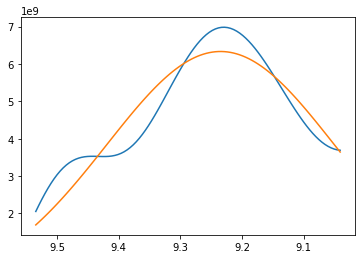

In [735]:
roi = 52
atom = "HN"

path_proj = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_proj.npy")
path_xdata = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_X.npy")

xdata = np.load(path_xdata)
ydata = np.load(path_proj)

p0 = (ydata.max(), xdata[np.argmax(ydata)], 0.5)        # initial guess
popt, pcov = curve_fit(gauss1d, xdata, ydata, p0=p0)
fit = gauss1d(xdata, *popt) 

plt.plot(xdata, ydata)
plt.gca().invert_xaxis()
plt.plot(xdata, fit)
print("Linewidth by fit: ", 2.355*popt[2], " ppm")
print("Linewidth by fit: ", 2.355*popt[2]*spectrum_dic["FDF1OBS"], " Hz")

#### All fits on the plot

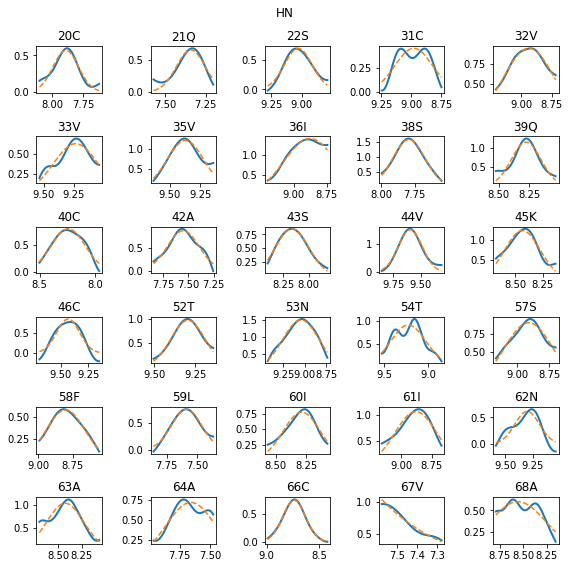

In [933]:
#spectrum_proj_fit.index.shape

atom="HN" # "CB" # "N"

fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0

spectrum_peak_list.sort_index(level=0,inplace=True)

for roi in spectrum_peak_list.index.get_level_values(0):
    if roi > 70: #exclude the strange additional peaks for now
        continue
    
    path_proj = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_proj.npy")
    path_xdata = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_X.npy")

    xdata = np.load(path_xdata)
    ydata = np.load(path_proj) / 1e10
    ydata_fit = gauss1d(xdata, 
                        I=spectrum_proj_fit.loc[(roi,), (atom,"Int")].values[0], 
                        x0=spectrum_proj_fit.loc[(roi,), (atom,"x0")].values[0], 
                        sigma=spectrum_proj_fit.loc[(roi,), (atom,"LW")].values[0]) / 1e10
    
    axs[row,col].plot(xdata, ydata, lw=2)
    axs[row,col].plot(xdata, ydata_fit, linestyle='--', markersize=0.2)
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis()
    col+=1
    if col==5:
        col=0
        row+=1
fig.suptitle(atom)
fig.tight_layout()
fig.savefig(dataDir+f"{atom}_fits.pdf", format="pdf")

WRITING the *automatic* fits to the disk. 

CAREFUL - will overwrite the existing file.

In [54]:
spectrum_proj_fit.to_csv(dataDir+"LW_fits_raw_111.tab", sep="\t", float_format='{:.2f}')

NameError: name 'spectrum_proj_fit' is not defined

#### It is a bit more complex with HN planes due to the overlap. 

Needs manual adjustments!

Linewidth by fit:  86.89353968896644  Hz
Int	10059840686.369625
center	7.605180115303766
sigma	0.18338003066063832


C:\Users\Admin\AppData\Local\Temp\ipykernel_35344\2081912273.py:44: PerformanceWarning: indexing past lexsort depth may impact performance.
  HNCA_proj_fit.loc[(roi,), (atom,)] = popt


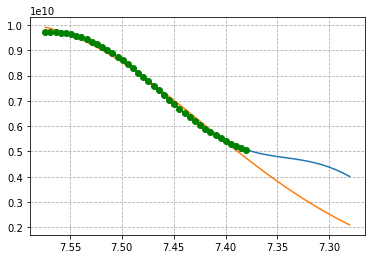

In [978]:
roi = 67
atom = "HN"

manual_fit = True # Do you want to calculate the automatic fit?

dataDir = "C:\\Users\\Admin\\Documents\\IPythonNotebooks\\Analysis of the peak shapes\\Hydrophobin\\IndPeaks\\3D\\HNCB\\"

path_proj = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_proj.npy")
path_xdata = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_X.npy")

xdata = np.load(path_xdata)
xdata_trunk = xdata[0 : xdata.shape[0] // 2+10]
ydata = np.load(path_proj)
ydata_trunk = ydata[0 : ydata.shape[0] // 2+10]

p0 = (ydata.max(), xdata[np.argmax(ydata)], 0.5) #initial guess for the automatic fit
bounds = ([2e9, 7.5, -0.5], [1e11, 7.7, 0.99]) # for the manual adjustments

if manual_fit:
    # Adjusted manually
    popt, pcov = curve_fit(gauss1d, xdata_trunk, ydata_trunk, 
                           bounds=bounds)
else:
    # Automatic fit
    popt, pcov = curve_fit(gauss1d, xdata, ydata, 
                           p0=p0)

fit = gauss1d(xdata, *popt)

plt.plot(xdata, ydata)
plt.gca().invert_xaxis()
plt.plot(xdata, fit)
plt.grid(True, ls='--')
plt.plot(xdata_trunk, ydata_trunk, 'go-')

#print("Linewidth by fit: ", 2.355*popt[2], " ppm")
print("Linewidth by fit: ", 2.355*popt[2]*spectrum_dic["FDF1OBS"], " Hz")
print(f"Int\t{popt[0]}\ncenter\t{popt[1]}\nsigma\t{popt[2]}")

spectrum_peak_list.loc[roi, f"projLW_{atom}"] = 2.355*popt[2]*obs_freq

spectrum_proj_fit.loc[(roi,), (atom,)] = popt

#### If the data has been created already, load the dataset from this **checkpoint**

File `C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\3Ds_LW_fits_corr.tab`

In [69]:
## spectrum_proj_fit = pd.read_csv(dataDir+"3Ds_LW_fits_corr.tab", sep="\t", index_col=[0,1], header=[0,1])

#### Plot the manually adjusted 1D fits

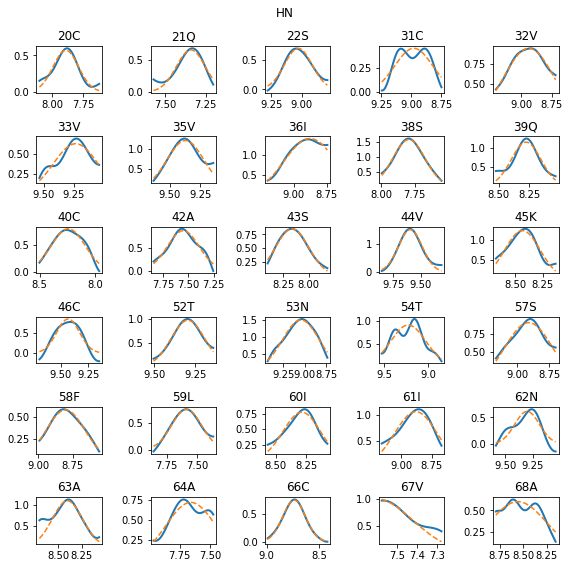

In [979]:
atom="HN"
fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0

spectrum_peak_list.sort_index(level=0,inplace=True)
for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    if roi > 70: #exclude the strange additional peaks for now
        continue
    
    path_proj = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_proj.npy")
    path_xdata = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+atom+"_X.npy")

    xdata = np.load(path_xdata)
    ydata = np.load(path_proj) / 1e10
    ydata_fit = gauss1d(xdata, 
                        I=spectrum_proj_fit.loc[(roi,), (atom,"Int")].values[0], 
                        x0=spectrum_proj_fit.loc[(roi,), (atom,"x0")].values[0], 
                        sigma=spectrum_proj_fit.loc[(roi,), (atom,"LW")].values[0]) / 1e10
    
    axs[row,col].plot(xdata, ydata, lw=2)
    axs[row,col].plot(xdata, ydata_fit, linestyle='--', markersize=0.2)
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis() 
    col+=1
    if col==5:
        col=0
        row+=1
fig.suptitle(atom)
fig.tight_layout()
### fig.savefig(dataDir+f"{atom}_fits_man_corr.pdf", format="pdf")

#### **WRITING** the data with manual corrections

Proceed with CAUTION!!! Will OVERWRITE the manually refined data!!

In [74]:
flag = input("Write the new REFINED 2D fits in the file? (Y/N)")
if flag == "Y": 
    #####spectrum_proj_fit.to_csv(dataDir+"3Ds_LW_fits_corr.tab", sep="\t")
    spectrum_proj_fit.to_csv(dataDir+"3Ds_LW_fits_corr_TEMP.tab", sep="\t")
    print("Fits are saved as", dataDir+"3Ds_LW_fits_corr_TEMP.tab")
else:
    print("Nothing is written")
flag="N"

Write the new REFINED 2D fits in the file? (Y/N) Y


Fits are saved as C:\Users\Admin\Documents\IPythonNotebooks\Analysis of the peak shapes\Hydrophobin\IndPeaks\3D\HNCB\3Ds_LW_fits_corr_TEMP.tab


## 3.2 Analysis of the 1D fits

### How similar are the projection fits to CCPN estimations?

<AxesSubplot:xlabel='LW_HN', ylabel='projLW_HN'>

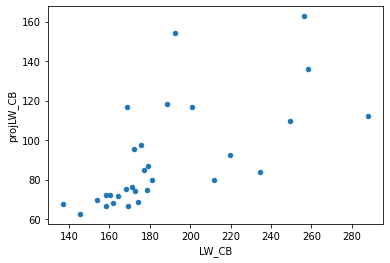

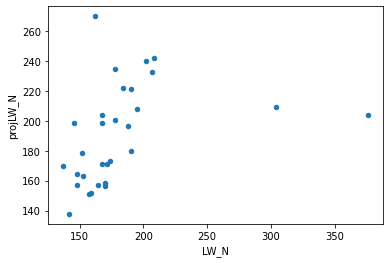

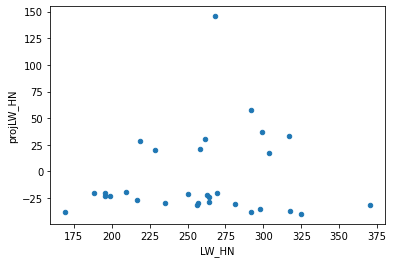

In [676]:
spectrum_peak_list.plot.scatter(x = "LW_CB", y="projLW_CB")
spectrum_peak_list.plot.scatter(x = "LW_N", y="projLW_N")
spectrum_peak_list.plot.scatter(x = "LW_HN", y="projLW_HN")
### Correlation???

### Bar plots

In [75]:
sequence = "SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA" 
nums = np.linspace(1,len(sequence),len(sequence))

labels = [str(int(n))+t for n, t in zip(nums, sequence)]
print("Labels for plots of a property against the residue:\n\n", labels)

Labels for plots of a property against the residue:

 ['1S', '2A', '3T', '4T', '5I', '6G', '7P', '8N', '9T', '10C', '11S', '12I', '13D', '14D', '15Y', '16K', '17P', '18Y', '19C', '20C', '21Q', '22S', '23M', '24S', '25G', '26S', '27A', '28S', '29L', '30G', '31C', '32V', '33V', '34G', '35V', '36I', '37G', '38S', '39Q', '40C', '41G', '42A', '43S', '44V', '45K', '46C', '47C', '48K', '49D', '50D', '51V', '52T', '53N', '54T', '55G', '56N', '57S', '58F', '59L', '60I', '61I', '62N', '63A', '64A', '65N', '66C', '67V', '68A']


#### Organising the data in a dataframe:

In [981]:
bars2plot = spectrum_proj_fit.reset_index().drop_duplicates()

# Filling the missing residues from the sequence
bars2plot = pd.merge(bars2plot, 
            pd.DataFrame(index=nums, columns=["ResNum"], data=nums),
            on=['ResNum'], 
            how="right"
                )

bars2plot.tail(20)

C:\Users\Admin\AppData\Local\Temp\ipykernel_35344\3833060444.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  bars2plot = pd.merge(bars2plot,


Atom  ResNum ResType             HN                        CB             \
Param                           Int   x0    LW            Int    x0   LW   
0       1.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
1       2.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
2       3.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
3       4.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
4       5.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
..       ...     ...            ...  ...   ...            ...   ...  ...   
63     64.00       A  7213174919.05 7.66 -0.20 49585196609.49 15.21 0.85   
64     65.00     NaN            NaN  NaN   NaN            NaN   NaN  NaN   
65     66.00       C  7416841438.81 8.74 -0.11 74063748569.09 41.58 0.38   
66     67.00       V 10059840686.37 7.61  0.18 71906200033.48 35.57 0.39   
67     68.00       A  6012682986.81 8.56  0.30 72851209629.56 16.11 0.62   

Atom               N              
Param            Int     x0   LW  
0                NaN    NaN  NaN  
1                NaN    NaN  NaN  
2                NaN    NaN  NaN  
3                NaN    NaN  NaN  
4                NaN    NaN  NaN  
..               ...    ...  ...  
63    33816882264.56 117.94 1.23  
64               NaN    NaN  NaN  
65    31240894617.19 120.10 0.96  
66    32591499899.01 118.50 0.90  
67    48650292892.47 127.95 0.91  

[68 rows x 11 columns]

individual charts

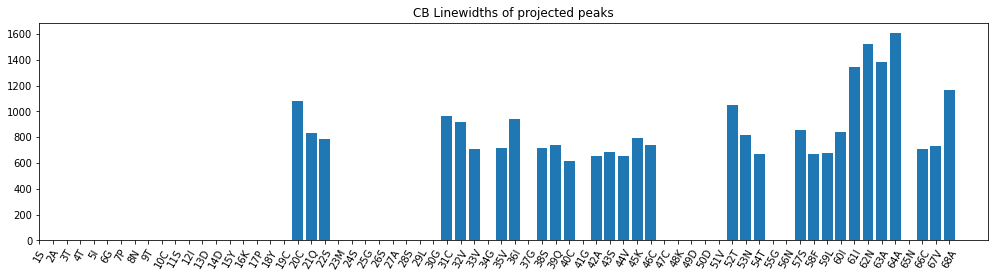

In [984]:
atom = "CB"
obs_freq = spectrum_dic["FDF2OBS"]

fig, ax = plt.subplots(figsize=(17,4))
ax.bar(x=nums, height=abs(bars2plot[(atom, "LW")].values*2.355*obs_freq))
ax.set_xticks(nums)
ax.set_xticklabels(labels, rotation=60)
ax.set_title(atom+" Linewidths of projected peaks")
plt.show()
fig.savefig(dataDir+f"{atom}_LW_chart.png", format="png", dpi=200)

#### Altogether

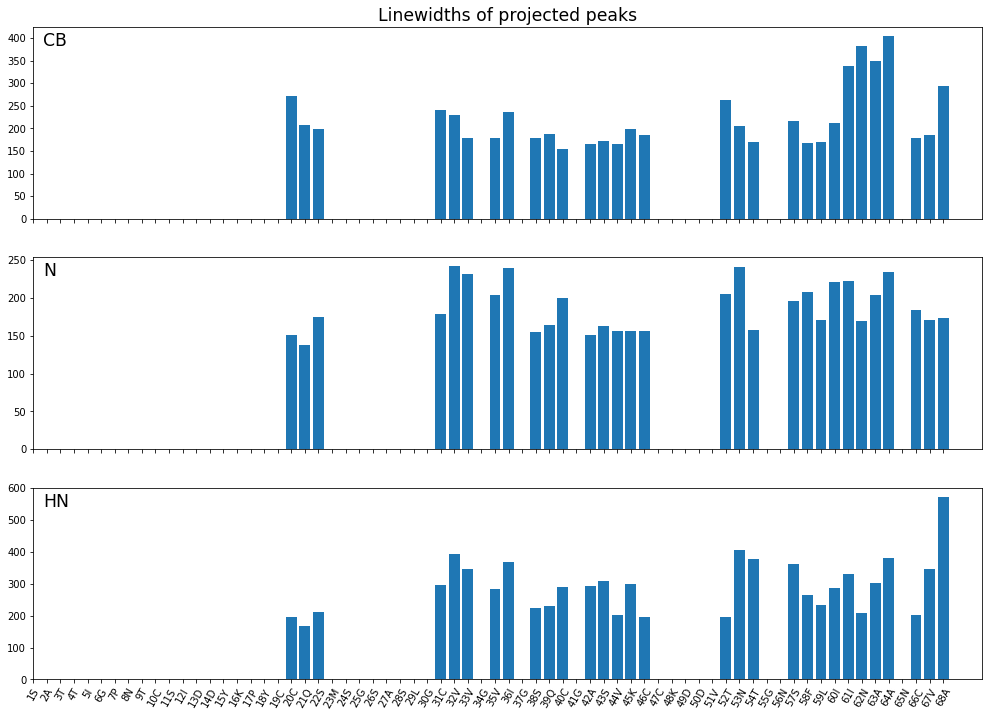

In [985]:
import matplotlib.transforms as mtransforms

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)

fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(17,12), sharex=True)
i=0
for atom, obs_freq in zip("CB N HN".split(), [spectrum_dic["FDF1OBS"], spectrum_dic["FDF3OBS"], spectrum_dic["FDF2OBS"]]):
    axs[i].bar(x=nums, height=abs(bars2plot[(atom, "LW")].values*2.355*obs_freq))
    axs[i].set_xticks(nums)
    axs[i].set_xticklabels(labels, rotation=60)
    #axs[i].grid(False, ls='--', axis='y',)
    axs[i].text(0.0, 1.0, atom, transform=axs[i].transAxes + trans,
        fontsize='xx-large', verticalalignment='top', #fontfamily='serif',
        #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
               )   
    i+=1
axs[0].set_title("Linewidths of projected peaks", fontsize='xx-large')
plt.show()
fig.savefig(dataDir+f"Full_LW_chart.pdf", format="pdf", dpi=200)

#### Linewidths and intensities

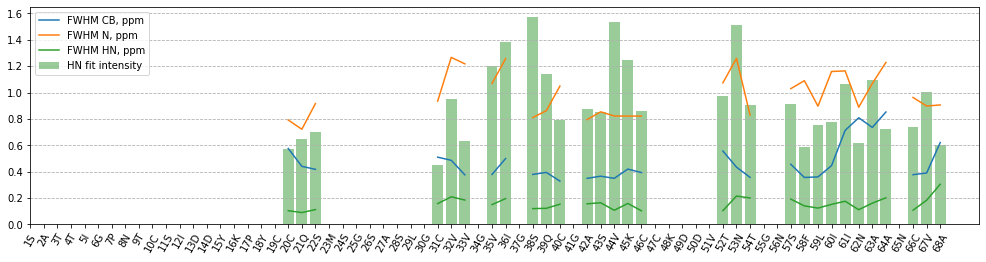

In [986]:
fig, axs = plt.subplots(figsize=(17,4))

axs.bar(x=nums, height=abs(bars2plot[("HN", "Int")].values)/1e10, fc="green", alpha=0.4, label="HN fit intensity")

for atom in "CB N HN".split():
    axs.plot(nums, abs(bars2plot[(atom, "LW")].values), label=f"FWHM {atom}, ppm")
    
axs.set_xticks(nums)
axs.set_xticklabels(labels, rotation=60)

axs.grid(True, ls='--', axis='y',)
axs.legend(loc=2)

#fig.tight_layout()
fig.savefig(dataDir+f"LW and peak intensity.png", format="png", dpi=200)

-------------

# 4. 2D fits 

2D fitting is a bit more sensitive to the artifacts. Therefor, the boxes are cleaned from the noise. 

Implementation of noise removal:
* Intensity floor applied: points below a threshold of 0.15 of the maximum (in the box) are replaced with 0; 
* The (only) large cluster of the remaining intense points is selected (semi-manually :D) - with help of `scipy.ndimage`

## 4.1 Preparing the data

### 4.1.1 Noise removal

Threshold test:

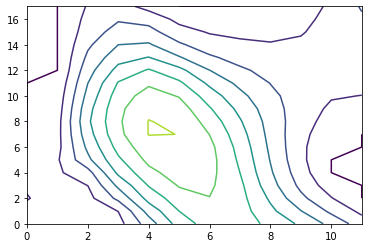

In [852]:
roi=52
fname_arr = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak.npy")
cube = np.load(fname_arr)
peak = np.where(cube < cube.max()*0.15, 0, cube)
plt.contour(peak.sum(axis=2))

Every peak is saved in the data directory as a numpy array. 
* `XX_Peak_0.15_int.npy` - for boxes without noise
* `XX_Peak_stripped.npy` - for selected cluster only

XX stands for residue number

In [55]:
for roi in spectrum_peak_list.index.get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue

    fname_arr = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak.npy")
    cube = np.load(fname_arr)
    peak = np.where(cube < spectrum.max()*0.15, 0, cube)
    
    np.save(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_0.15_int.npy"), peak)

In [996]:
from scipy import ndimage
s = ndimage.generate_binary_structure(3,2) # smoothens the edges

for roi in spectrum_peak_list.index.get_level_values(0):
    
    print(roi)
    if roi > 70: #exclude the strange additional peaks for now
        continue

    fname_peak = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_0.15_int.npy")
    peak = np.load(fname_peak)
    labels, num_features = ndimage.label(peak, structure=s)
    
    print("Cluster maxima: \n", ndimage.maximum(peak, labels=labels, index=np.arange(1, num_features + 1)))
    
    # bad idea to check by intensity
    #main_cluster_id = np.argmax(ndimage.maximum(peak, labels=labels, index=np.arange(1, num_features + 1)))
    # good idea: check by cluster area??
    amount, _ = np.histogram(labels.ravel(), bins=num_features)
    print("Number of clusters \t", num_features)
    if num_features>1:
        main_cluster_id = np.argmax(amount[1:])+1 #starting from one because zero is not a cluster, it is the floor
    else: 
        main_cluster_id = 1
    print("Main cluster id \t", main_cluster_id) 
    print('\n')
    peak_stripped = np.where(labels==main_cluster_id, peak, 0)
    np.save(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"), peak_stripped)

20
Cluster maxima: 
 [58658500.]
Number of clusters 	 1
Main cluster id 	 1


21
Cluster maxima: 
 [78537320.]
Number of clusters 	 1
Main cluster id 	 1


22
Cluster maxima: 
 [73549320. 44342108.]
Number of clusters 	 2
Main cluster id 	 1


31
Cluster maxima: 
 [60100880.]
Number of clusters 	 1
Main cluster id 	 1


32
Cluster maxima: 
 [5.1476116e+07 1.3377933e+08]
Number of clusters 	 2
Main cluster id 	 1


33
Cluster maxima: 
 [88799648. 46109940.]
Number of clusters 	 2
Main cluster id 	 1


35
Cluster maxima: 
 [1.6779691e+08 5.0888260e+07]
Number of clusters 	 2
Main cluster id 	 1


36
Cluster maxima: 
 [1.2964762e+08]
Number of clusters 	 1
Main cluster id 	 1


38
Cluster maxima: 
 [2.2996026e+08]
Number of clusters 	 1
Main cluster id 	 1


39
Cluster maxima: 
 [2.0358384e+08 4.4110636e+07]
Number of clusters 	 2
Main cluster id 	 1


40
Cluster maxima: 
 [1.1247218e+08]
Number of clusters 	 1
Main cluster id 	 1


42
Cluster maxima: 
 [1.8937827e+08]
Number of clusters 

Visualisation of the result:

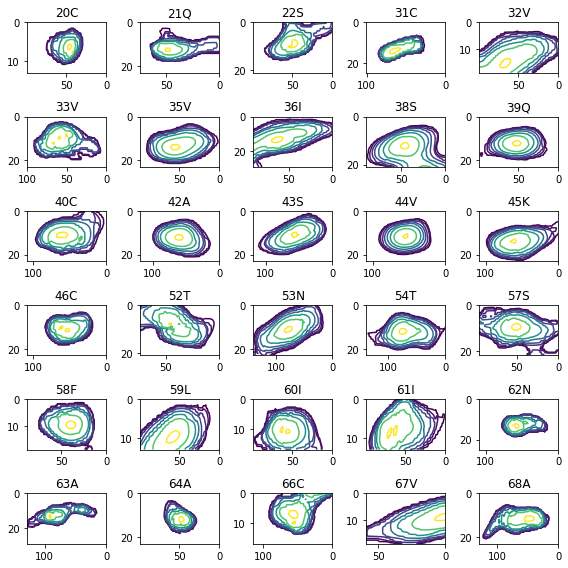

In [12]:
fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0


for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue
    
    peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))    
    proj = peak_stripped.sum(axis=1) ##### HN projection
    
    cl = [0.155*proj.max()*1.3**x for x in range(8)]
    axs[row,col].contour(proj, cl) 
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis() 
    axs[row,col].invert_yaxis() 
    col+=1
    if col==5:
        col=0
        row+=1
fig.tight_layout()
fig.savefig(dataDir+f"2D_peaks_clean_0.15int_HN_projs.pdf", format="pdf", dpi=200)

2


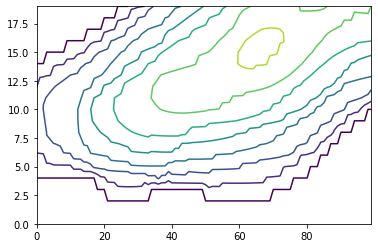

In [999]:
roi = 32

fname_peak = os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_0.15_int.npy")
peak = np.load(fname_peak)
labels, num_features = ndimage.label(peak, structure=s)
print(num_features)
peak_stripped = np.where(labels==2, peak, 0)
plt.contour(peak_stripped.sum(axis=1)) # HN projection
np.save(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"), peak_stripped)

### 4.1.2 2D gaussian fits

#### Definitions

In [895]:
### Fail!!!!

def gauss2d(Xdata, I, X0, Sigma, rho):
    x, y = Xdata[0], Xdata[1]
    x = x.ravel()
    y = y.ravel()
    x0, y0 = X0[0], X0[1]
    sigma_x, sigma_y = Sigma[0], Sigma[1]
    
    f = I * np.exp(- 1/(2*(1-rho**2)) *( 
                     ((x-x0)/sigma_x))**2 
                   - 2*rho*(x-x0)*(y-y0)/(sigma_x*sigma_y) 
                   + ((y-y0)/sigma_y)**2
                  )
    return f.reshape(Xdata[0].shape)

## 1D version
# I * np.exp(-1/2*(x-x0)**2/(sigma**2))

In [14]:
# Success

def twoD_Gaussian(xdata_tuple, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                                 
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0)         
                        + c*((y-y0)**2))) 
    
    #f = I * np.exp(- 1/(2*(1-theta**2)) *( 
    #                 ((x-x0)/sigma_x))**2 
    #               - 2*theta*(x-x0)*(y-y0)/(sigma_x*sigma_y) 
    #               + ((y-y0)/sigma_y)**2
    #              )
    return g.ravel()

gauss test:

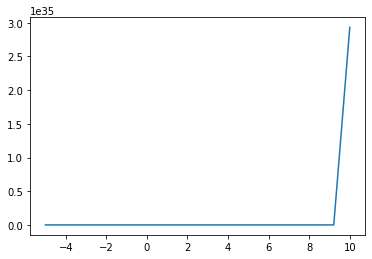

In [898]:
# Failed function

Xdata = np.meshgrid(np.linspace(-5,10,20), 
                   np.linspace(-5,10,20))
X0 = [5, 2]
Sigma = [3, 1]
rho = 0.4
I = 10

gauss_data = gauss2d(Xdata, I, X0, Sigma, rho)
#plt.contour(np.linspace(-10,10,20), np.linspace(-10,10,20), gauss_data)
plt.plot(np.linspace(-5,10,20), gauss_data.sum(axis=1))

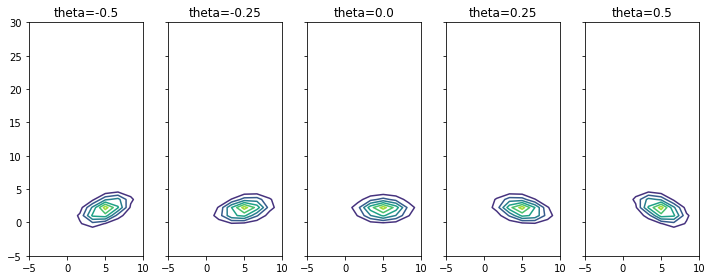

In [774]:
# Good function!

Xdata = np.meshgrid(np.linspace(-5,10,10), 
                   np.linspace(-5,30,30))
x0, y0 = [5, 2]
sigma_x, sigma_y = [2, 1]
theta = -1*np.pi*1/4
I = 10
offset = 0
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,4),sharey=True)
i=0
for theta in np.linspace(-0.5, 0.5, 5):
    gauss_data = twoD_Gaussian(Xdata, I, x0, y0, sigma_x, sigma_y, theta, offset)
    gauss_data = gauss_data.reshape(Xdata[0].shape)

    ax[i].contour(np.linspace(-5,10,10), np.linspace(-5,30,30), gauss_data)
    ax[i].set_title(f"theta={theta}")
    i+=1
fig.tight_layout()
plt.show()

#### Test fit of an individual residue

Playing around with the individual peaks

amplitude	x0	y0	sigma_x	sigma_y	theta	offset
 [175091654.037, 49.99, 9.523, 21.393, 2.914, 0.011, 45166728.598]


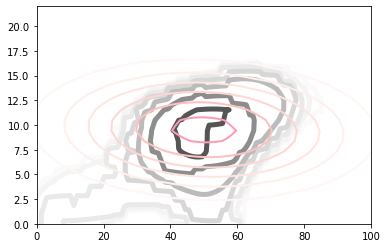

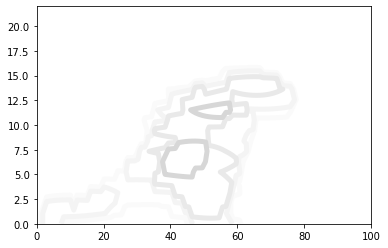

In [776]:
roi = 22

peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
HN_proj = peak_stripped.sum(axis=1)

x = np.linspace(0,HN_proj.shape[1],HN_proj.shape[1])
y = np.linspace(0,HN_proj.shape[0],HN_proj.shape[0])

Xdata = np.meshgrid(x, y)

#                 amplitude,   y0, x0, sigma_y, sigma_x, theta,    offset
#initial_guess = [HN_proj.max(), 75, 75, 20,    20,     0.1,   0.15*HN_proj.max()]

#x_, y_ = np.unravel_index(np.argmax(HN_proj_Big), HN_proj_Big.shape)
id_y0, id_x0 = np.unravel_index(np.argmax(HN_proj), HN_proj.shape)
x0 = x[id_x0]
y0 = y[id_y0]

sigma_x = np.sqrt(np.sum(HN_proj * (Xdata[0] - x0)**2) / np.sum(HN_proj))
sigma_y = np.sqrt(np.sum(HN_proj * (Xdata[1] - y0)**2) / np.sum(HN_proj))

bounds = [ [HN_proj.max()*0.1, x0*0.99,  y0*0.99,   sigma_x*0.1,  sigma_y*0.1,  -1*np.pi*1/4,   -1*np.inf],
           [HN_proj.max()*1.5, x0*1.01,  y0*1.01,   sigma_x*1.2,  sigma_y*1.2,    np.pi*1/4,     np.inf]]

popt, pcov = curve_fit(twoD_Gaussian, Xdata, HN_proj.T.ravel(), #initial_guess, 
                       bounds=bounds) #Do NOT forget to transpose the data array!!!

fit_data = twoD_Gaussian(Xdata, *popt)
fit_data = fit_data.reshape(HN_proj.shape)

cl = [0.15*HN_proj.max()*1.3**x for x in range(9)]

plt.contour(x, y, HN_proj,  cl, cmap="Greys", linewidths=5)
plt.contour(x, y, fit_data, cl, cmap="RdPu", linewidths=2)
plt.figure()
plt.contour(x, y, HN_proj-fit_data, cl, cmap="Greys", linewidths=5)
print("amplitude\tx0\ty0\tsigma_x\tsigma_y\ttheta\toffset\n", [round(x, 3) for x in popt])

#### Automatic fits

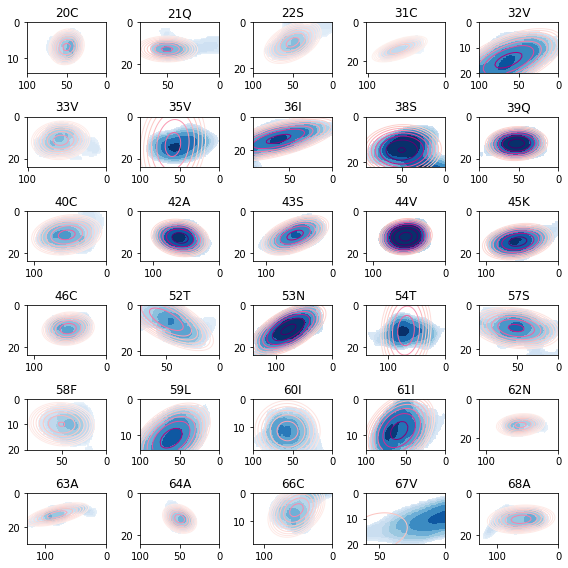

In [1001]:
spectrum_HN_2D_fits = pd.DataFrame(columns="Amplitude N_cent_pts H_cent_pts sigma_N sigma_H theta offset".split())

fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0

for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue
      
    peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
    HN_proj = peak_stripped.sum(axis=1)
    x = np.linspace(0,HN_proj.shape[0],HN_proj.shape[0])
    y = np.linspace(0,HN_proj.shape[1],HN_proj.shape[1])
    Xdata = np.meshgrid(x, y)

    #                 amplitude,   y0, x0, sigma_y, sigma_x, theta,    offset
#    initial_guess = [HN_proj.max(), 4, 80, 0.75,    4.75,     0.1,   0.15*HN_proj.max()]

    bounds = [ [HN_proj.max()*0.2, 3,  50,   1.75,  1.00,   -0.5,   -np.inf],
               [HN_proj.max()*1.5, 15, 90,   60.75, 60.85,   0.5,    np.inf]]

    popt, pcov = curve_fit(twoD_Gaussian, Xdata, HN_proj.T.ravel(), bounds=bounds) #Do NOT forget to transpose the data array!!

    spectrum_HN_2D_fits.loc[roi] = popt
    spectrum_HN_2D_fits = spectrum_HN_2D_fits.apply(lambda x: round(x, 3))
    fit_data = twoD_Gaussian(Xdata, *popt)
    fit_data = fit_data.reshape(Xdata[0].shape)

    cl = [0.15*HN_proj.max()*1.3**x for x in range(10)]

    axs[row,col].contourf(y, x, HN_proj, cl, cmap="Blues", vmin=6e5, vmax=9e8) # HN projection
    axs[row,col].contour(y, x, fit_data.T, cl, cmap="RdPu", linewidths=1, vmin=6e5, vmax=9e8) # HN projection
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis() 
    axs[row,col].invert_yaxis() 
    #axs[row,col].set_ylim(30, 0) 
    #axs[row,col].set_xlim(180, 0) 
    col+=1
    if col==5:
        col=0
        row+=1
#plt.colorbar(axs[row,col].contourf(y, x, HN_proj, cl, cmap="Blues", vmin=6e5, vmax=9e8), cax=axs[-1,-1])
#axs[-1,-1].set_yticks(np.linspace(0.1,1.1,5)*HN_proj.max())
spectrum_HN_2D_fits.to_csv(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_raw.tab", sep="\t")
fig.tight_layout()
#fig.savefig(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_raw_constant_scale.pdf", format="pdf", dpi=200)

as usual, manual corrections (peaks differ largly by width, and `curve_fit` requires bounds close to the true parameters. Therefore fits that just use general parameters are not perfect)

	Peak 	 278.9913330078125	Residual	 5.084207499450599e-09	Peak / Residual = 54874104378.7

amplitude	x0	y0	sigma_x	sigma_y	theta	offset
 [784171414.894, 9.548, 1.764, 4.781, 31.776, 0.121, -40905487.141]


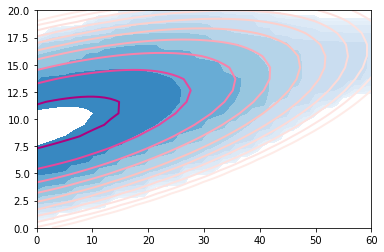

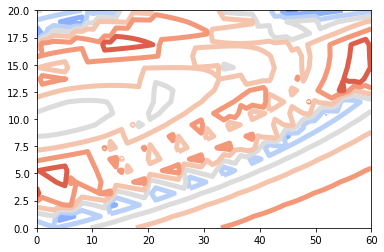

In [17]:
roi = 67

#                 amplitude,   y0, x0, sigma_y, sigma_x, theta,    offset
#    initial_guess = [HN_proj.max(), 4, 80, 0.75,    4.75,     0.1,   0.15*HN_proj.max()]

peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
HN_proj = peak_stripped.sum(axis=1)
x = np.linspace(0,HN_proj.shape[0],HN_proj.shape[0])
y = np.linspace(0,HN_proj.shape[1],HN_proj.shape[1])
Xdata = np.meshgrid(x, y)

#                 amplitude,   y0, x0, sigma_y, sigma_x, theta,    offset
#    initial_guess = [HN_proj.max(), 4, 80, 0.75,    4.75,     0.1,   0.15*HN_proj.max()]

bounds = [ [HN_proj.max()*0.2,  5, -20,   1.75,  1.00,   -0.9,   -np.inf],
           [HN_proj.max()*1.5, 15, 80,   30.75, 50.85,   1.0,   np.inf]]

popt, pcov = curve_fit(twoD_Gaussian, Xdata, HN_proj.T.ravel(), bounds=bounds) #Do NOT forget to transpose the data array!!

spectrum_HN_2D_fits.loc[roi] = popt
spectrum_HN_2D_fits = spectrum_HN_2D_fits.apply(lambda x: round(x, 3))
fit_data = twoD_Gaussian(Xdata, *popt)
fit_data = fit_data.reshape(Xdata[0].shape)
fit_residual = HN_proj-fit_data.T

print(f"\tPeak \t {np.sum(((HN_proj/1e9)))}\tResidual\t {np.sum(((fit_residual/1e9)))}\tPeak / Residual = {round (np.sum(((HN_proj/1e9))) / np.sum(((fit_residual/1e9))), 1)}")
print()
# cl = [0.15*HN_proj.max()*1.3**x for x in range(9)]

plt.contourf(y, x, HN_proj, cl, cmap="Blues", vmin=6e5, vmax=9e8)
plt.contour(y, x, fit_data.T, cl, cmap="RdPu", linewidths=2, vmin=6e5, vmax=9e8)
plt.figure()
plt.contour(y, x, fit_residual, cmap="coolwarm", linewidths=5)
print("amplitude\tx0\ty0\tsigma_x\tsigma_y\ttheta\toffset\n", [round(x, 3) for x in popt])

spectrum_HN_2D_fits.to_csv(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_corr.tab", sep="\t")

#### Manually corrected fits

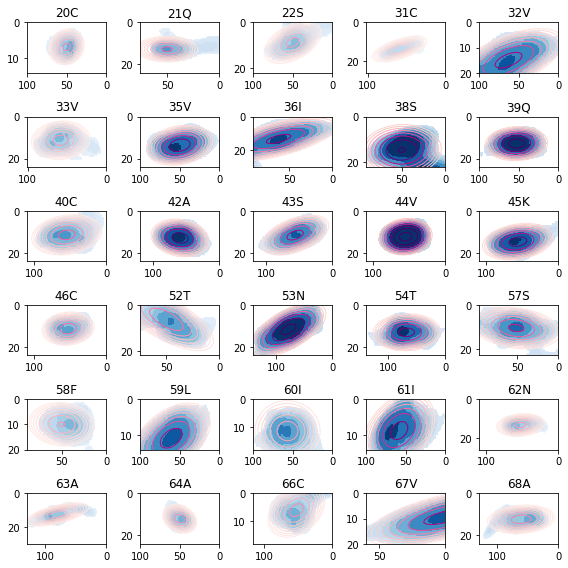

In [18]:
#del spectrum_HN_2D_fits
spectrum_HN_2D_fits = pd.read_csv(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_corr.tab", sep="\t", index_col=0)

fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0

for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue
      
    peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
    HN_proj = peak_stripped.sum(axis=1)
    x = np.linspace(0,HN_proj.shape[0],HN_proj.shape[0])
    y = np.linspace(0,HN_proj.shape[1],HN_proj.shape[1])
    Xdata = np.meshgrid(x, y)

    fit_params = spectrum_HN_2D_fits.loc[roi].values
    fit_data = twoD_Gaussian(Xdata, *fit_params)
    fit_data = fit_data.reshape(Xdata[0].shape)
    cl = [0.15*HN_proj.max()*1.3**x for x in range(10)]

    axs[row,col].contourf(y, x, HN_proj, cl, cmap="Blues", vmin=6e5, vmax=9e8) # HN projection
    axs[row,col].contour(y, x, fit_data.T, cl, cmap="RdPu", linewidths=1, vmin=6e5, vmax=9e8) # HN projection
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis() 
    axs[row,col].invert_yaxis() 
    #axs[row,col].set_ylim(30, 0) 
    #axs[row,col].set_xlim(180, 0) 
    col+=1
    if col==5:
        col=0
        row+=1
#plt.colorbar(axs[row,col].contourf(y, x, HN_proj, cl, cmap="Blues", vmin=6e5, vmax=9e8), cax=axs[-1,-1])
#axs[-1,-1].set_yticks(np.linspace(0.1,1.1,5)*HN_proj.max())

fig.tight_layout()
#fig.savefig(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_raw_constant_scale.pdf", format="pdf", dpi=200)

Fit residuals

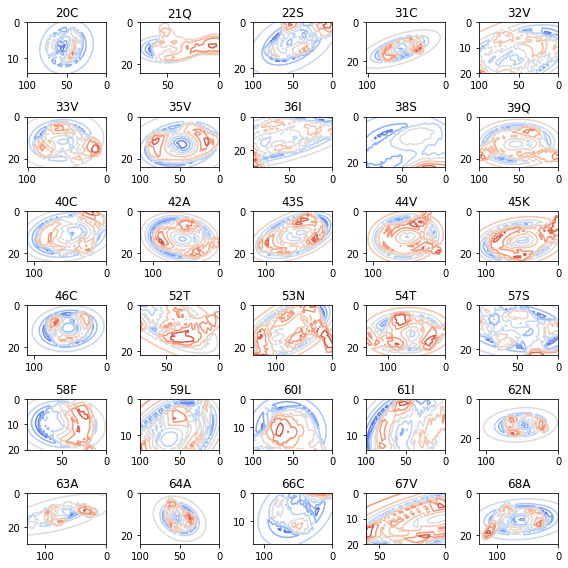

In [19]:
fig, axs = plt.subplots(figsize=(8,8),nrows=6, ncols=5) 

row=0
col=0

for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue
      
    peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
    HN_proj = peak_stripped.sum(axis=1)
    x = np.linspace(0,HN_proj.shape[0],HN_proj.shape[0])
    y = np.linspace(0,HN_proj.shape[1],HN_proj.shape[1])
    Xdata = np.meshgrid(x, y)

    fit_params = spectrum_HN_2D_fits.loc[roi].values
    fit_data = twoD_Gaussian(Xdata, *fit_params)
    fit_data = fit_data.reshape(Xdata[0].shape)
    fit_residual = HN_proj-fit_data.T

    #cl = [0.15*fit_residual.max()*1.3**x for x in range(10)]

    axs[row,col].contour(y, x, fit_residual, cmap="coolwarm") # HN projection
    axs[row,col].set_title(f"{roi}{spectrum_proj_fit.loc[roi].index[0]}")
    axs[row,col].invert_xaxis() 
    axs[row,col].invert_yaxis() 
    #axs[row,col].set_ylim(30, 0) 
    #axs[row,col].set_xlim(180, 0) 
    col+=1
    if col==5:
        col=0
        row+=1
#plt.colorbar(axs[row,col].contour(y, x, fit_residual, cmap="coolwarm"), cax=axs[-1,-1])

fig.tight_layout()
fig.savefig(dataDir+f"2D_peaks_clean_Residuals_of_HN_projs_corr.pdf", format="pdf", dpi=200)

#### **WRITING the fit data**

WILL OVERWRITE the existing file! Uncomment and run with caution!

In [61]:
## spectrum_HN_2D_fits.to_csv(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_corr.tab", sep="\t")

-----------

## 4.2 Analysis

#### **Load** the saved fit data:

In [62]:
spectrum_HN_2D_fits = pd.read_csv(dataDir+f"2D_peaks_clean_Fits_of_HN_projs_corr.tab", sep="\t")

In [60]:
sequence = "SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA" 
nums = np.linspace(1,len(sequence),len(sequence))

labels = [str(int(n))+t for n, t in zip(nums, sequence)]
print("Labels for plots of a property against the residue:\n\n", labels)

Labels for plots of a property against the residue:

 ['1S', '2A', '3T', '4T', '5I', '6G', '7P', '8N', '9T', '10C', '11S', '12I', '13D', '14D', '15Y', '16K', '17P', '18Y', '19C', '20C', '21Q', '22S', '23M', '24S', '25G', '26S', '27A', '28S', '29L', '30G', '31C', '32V', '33V', '34G', '35V', '36I', '37G', '38S', '39Q', '40C', '41G', '42A', '43S', '44V', '45K', '46C', '47C', '48K', '49D', '50D', '51V', '52T', '53N', '54T', '55G', '56N', '57S', '58F', '59L', '60I', '61I', '62N', '63A', '64A', '65N', '66C', '67V', '68A']


#### Plotting $\theta$ coefficients agains res number 

Looking at peak "diagonality" 

> $\theta$ shows how correlated two dimensions are, ranges from 0 to 1. $\theta = 1$ for 45° tilted Gaussian,  $\theta = 0$  for vertical or horizontal orientation (no correlation). See Section 3.2.2 - Definitions -  Gaussian tests for demonstration

In [63]:
theta2plot = spectrum_HN_2D_fits.reset_index()
theta2plot = pd.merge(theta2plot, 
            pd.DataFrame(index=nums, columns=["index"], data=nums), 
            #right_index=True,
            on="index",
            how="right"
                )

In [64]:
theta2plot.columns

Index(['index', 'Unnamed: 0', 'Amplitude', 'N_cent_pts', 'H_cent_pts',
       'sigma_N', 'sigma_H', 'theta', 'offset'],
      dtype='object')

In [65]:
theta2plot

,index,Unnamed: 0,Amplitude,N_cent_pts,H_cent_pts,sigma_N,sigma_H,theta,offset
0,1.0,21.0,4.846768e+08,12.715,50.000,2.950,14.165,-0.001,1.716207e+07
1,2.0,22.0,3.857212e+08,8.708,50.000,4.181,18.655,0.125,-4.442734e+06
2,3.0,31.0,2.708983e+08,13.685,58.695,2.609,17.790,0.117,-3.464748e+06
3,4.0,32.0,8.225262e+08,15.000,62.865,5.781,39.338,0.108,-6.892465e+07
4,5.0,33.0,4.146376e+08,11.273,58.017,4.714,19.217,0.019,-7.148155e+06
...,...,...,...,...,...,...,...,...,...
63,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Text(1, -1.5707963267948966, '-0.5Pi'),
 Text(1, -0.7853981633974483, '-0.25Pi'),
 Text(1, 0.0, '0.0Pi'),
 Text(1, 0.7853981633974483, '0.25Pi'),
 Text(1, 1.5707963267948966, '0.5Pi')]

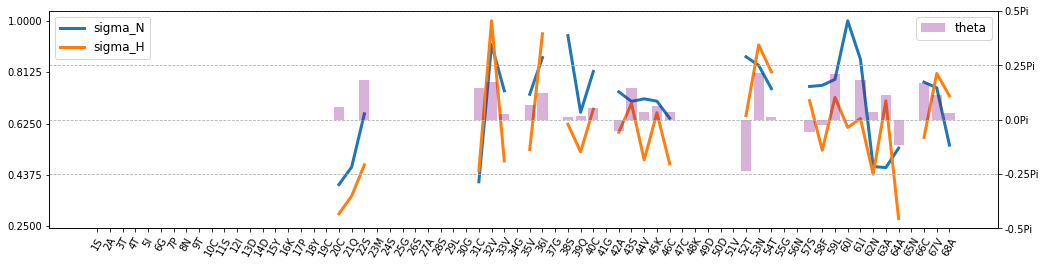

In [31]:
labels = [str(int(n))+t for n, t in zip(nums, sequence)]

fig, axs = plt.subplots(figsize=(17,4))

#axs.bar(x=nums, height=abs(bars2plot[("HN", "Int")].values)/1e10, fc="green", alpha=0.4, label="HN fit intensity")

for param in ['sigma_N', 'sigma_H']:
    values = abs(theta2plot[param].values)
    values /= theta2plot[param].fillna(0).max()
    axs.plot(nums, values, label=f"{param}", lw=3)

values = theta2plot['theta corr'].fillna(0).values 
axs2 = axs.twinx()
axs2.bar(nums, values, label='theta', fc='purple', alpha=0.3)    

axs.set_xticks(nums)
axs.set_xticklabels(labels, rotation=60)

axs2.grid(True, ls='--', axis='y',)
axs.legend(loc=2, fontsize=12)
axs2.legend(loc=1, fontsize=12)

axs.set_yticks(np.linspace(0.25, 1, 5))
axs2.set_yticks(np.linspace(-np.pi/2, np.pi/2, 5))
axs2.set_yticklabels([str(lab)+"Pi" for lab in np.linspace(-0.5, 0.5, 5)])

#fig.tight_layout()
#fig.savefig(dataDir+f"2D Fit_parameters_HN_proj.png", format="png", dpi=200)

In [28]:
for roi in spectrum_peak_list.index.drop_duplicates().get_level_values(0):
    
    if roi > 70: #exclude the strange additional peaks for now
        continue
      
    peak_stripped = np.load(os.path.join(os.path.join(dataDir, str(roi)), str(roi)+"_Peak_stripped.npy"))
    len_y, len_x = peak_stripped.sum(axis=1).shape
    
    spectrum_HN_2D_fits.loc[roi, "theta corr coeff"] = len_y / len_x
    spectrum_HN_2D_fits["theta corr coeff"] = spectrum_HN_2D_fits["theta corr coeff"].apply(lambda x: round(x, 3))
    
spectrum_HN_2D_fits["theta corr"] =  1/spectrum_HN_2D_fits["theta corr coeff"] * spectrum_HN_2D_fits["theta"]
spectrum_HN_2D_fits["theta corr"].max() / np.pi

0.21471791139024934

In [1551]:
HN_proj.shape

(22, 125)

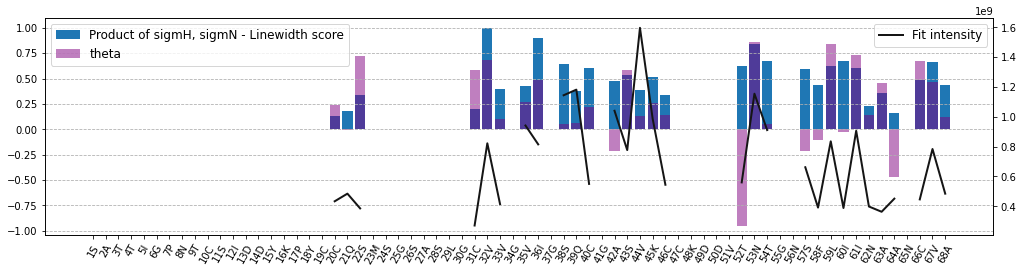

In [36]:
sequence = "SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA"
nums = np.linspace(1,len(sequence),len(sequence))
labels = [str(int(n))+t for n, t in zip(nums, sequence)]

fig, axs = plt.subplots(figsize=(17,4))

#axs.bar(x=nums, height=abs(bars2plot[("HN", "Int")].values)/1e10, fc="green", alpha=0.4, label="HN fit intensity")

values = abs(theta2plot[['sigma_N','sigma_H']].product(axis=1))
values /= theta2plot[['sigma_N','sigma_H']].product(axis=1).fillna(0).max()
axs.bar(nums, values, label=f"Product of sigmH, sigmN - Linewidth score")

axs2 = axs.twinx()
axs2.plot(nums, theta2plot["Amplitude"], label='Fit intensity', c='#151515', lw=2)   
axs.bar(nums, theta2plot["theta corr"]/np.pi*4, label='theta', fc='purple', alpha=0.5)    

axs.set_xticks(nums)
axs.set_xticklabels(labels, rotation=60)

axs.grid(True, ls='--', axis='y')
axs.legend(loc=2, fontsize=12)
axs2.legend(loc=1, fontsize=12)

#fig.tight_layout()
fig.savefig(dataDir+f"2D Produt of Fit_parameters_HN_proj.png", format="png", dpi=200)

In [35]:
spectrum_HN_2D_fits#[['sigma_N','sigma_H','theta']]

,Amplitude,N_cent_pts,H_cent_pts,sigma_N,sigma_H,theta,offset,theta corr coeff,theta corr
20,4.334976e+08,6.807,50.000,2.546,11.626,0.026,-6.500343e+06,0.140,0.185714
21,4.846768e+08,12.715,50.000,2.950,14.165,-0.001,1.716207e+07,0.316,-0.003165
22,3.857212e+08,8.708,50.000,4.181,18.655,0.125,-4.442734e+06,0.220,0.568182
31,2.708983e+08,13.685,58.695,2.609,17.790,0.117,-3.464748e+06,0.255,0.458824
32,8.225262e+08,15.000,62.865,5.781,39.338,0.108,-6.892465e+07,0.200,0.540000
33,4.146376e+08,11.273,58.017,4.714,19.217,0.019,-7.148155e+06,0.238,0.079832
35,9.418659e+08,13.626,49.769,4.632,20.850,0.051,-3.399223e+06,0.240,0.212500
36,8.153888e+08,13.276,62.345,5.481,37.481,0.124,-2.488421e+07,0.326,0.380368
38,1.144806e+09,14.610,50.000,5.990,24.495,0.010,-3.166939e+07,0.242,0.041322
39,1.182480e+09,12.862,52.783,4.215,20.513,0.012,-2.870178e+07,0.240,0.050000


-----

#### Correlation between CA and CB from 3D data

In [ ]:
dirspectrum = "C:\Users\Admin\OneDrive\Hydrophobin IndPeaks\3D\spectrum"
dirHNCB = "C:\Users\Admin\OneDrive\Hydrophobin IndPeaks\3D\HNCB"
HNCB_HN_2D_fits = 

----------------------